In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import os,sys
from scipy.stats.mstats import winsorize
import seaborn as sns
import sklearn
from sklearn.feature_selection import mutual_info_classif
plt.rcParams["font.sans-serif"]="Times New Roman"
import warnings
warnings.filterwarnings("ignore")

In [104]:
# 禁止函数内部输出
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [88]:
# 读取数据
train_data=pd.read_csv(r"Dataset/cs-training.csv",index_col="Unnamed: 0")
test_data=pd.read_csv(r"Dataset/cs-test.csv",index_col="Unnamed: 0")
column_names=["Default","Balance_r","Age","Worse_1m", "Debt_r","Income","Credit_num","Worse_3m","Estate_num","Worse_2m","Family_num"]
train_data.columns=column_names
test_data.columns=column_names

# 数据预处理


## 缺失值与异常值

In [89]:
# null检验
null_data=pd.DataFrame(pd.isna(train_data).sum(),columns=["Null_num"])
null_data["Null_percentage"]=null_data.Null_num/(train_data.count()+null_data.Null_num)
null_data.Null_percentage=null_data.Null_percentage.apply(lambda x: format(x,".2%"))
null_data

,Null_num,Null_percentage
Default,0,0.00%
Balance_r,0,0.00%
Age,0,0.00%
Worse_1m,0,0.00%
Debt_r,0,0.00%
Income,29731,19.82%
Credit_num,0,0.00%
Worse_3m,0,0.00%
Estate_num,0,0.00%
Worse_2m,0,0.00%


上面的表格展示了数据中null的数量, 总的观察点有150000个, 而null最多的feature有接近30000个null. 占比19.82%. 因此在后面的分析我们要非常小心缺失值的存在

In [90]:
# 数据特征 summary
train_data.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Default,150000.0,0.07,0.25,0.0,0.00,0.00,0.00,1.0
Balance_r,150000.0,6.05,249.76,0.0,0.03,0.15,0.56,50708.0
Age,150000.0,52.30,14.77,0.0,41.00,52.00,63.00,109.0
Worse_1m,150000.0,0.42,4.19,0.0,0.00,0.00,0.00,98.0
Debt_r,150000.0,353.01,2037.82,0.0,0.18,0.37,0.87,329664.0
Income,120269.0,6670.22,14384.67,0.0,3400.00,5400.00,8249.00,3008750.0
Credit_num,150000.0,8.45,5.15,0.0,5.00,8.00,11.00,58.0
Worse_3m,150000.0,0.27,4.17,0.0,0.00,0.00,0.00,98.0
Estate_num,150000.0,1.02,1.13,0.0,0.00,1.00,2.00,54.0
Worse_2m,150000.0,0.24,4.16,0.0,0.00,0.00,0.00,98.0


### Balance_r
一般来说, 我们认为Balance_r(授信额度/总信用额度)应该是在[0,1]的范围内取值的, 但是report的最大结果是50708. 我们有理由认为, 当Balance_r大于1时, 所得到的条目是是不可信的. 因此直接删去所有大于1的信息, 一共删去3321条.

In [91]:
train_data=train_data[~(train_data["Balance_r"]>1)]

### 不考虑未成年人的信用
一般来说, 未成年人不能办信用卡, 因此我们剔除所有未成年的数据, 一共删去1条

In [92]:
train_data = train_data[~(train_data["Age"]<20)]

## Outlier 离群值

观察各个数据的分位数和最大最小值可以看出, 每个feature都存在着outlier. 画出箱型图来侦测outlier

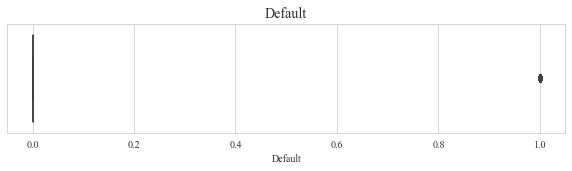

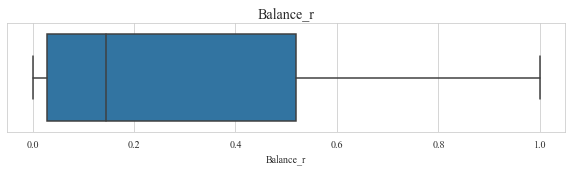

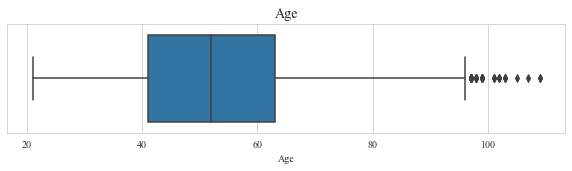

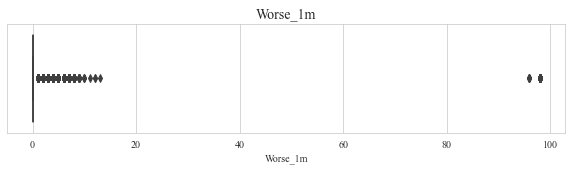

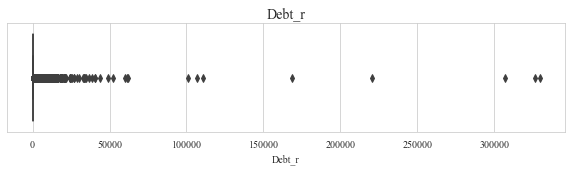

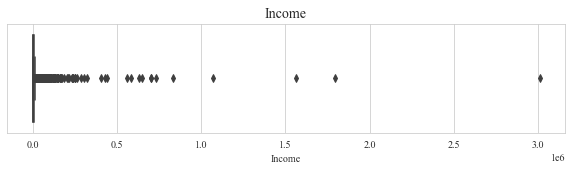

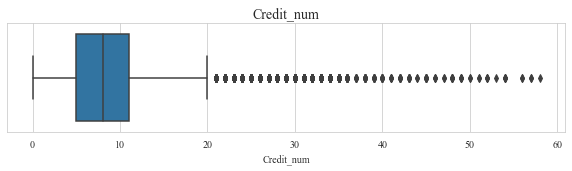

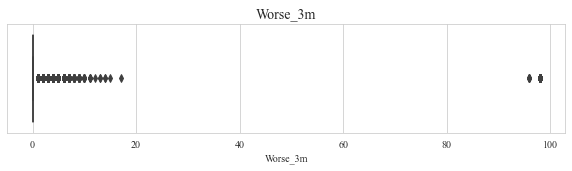

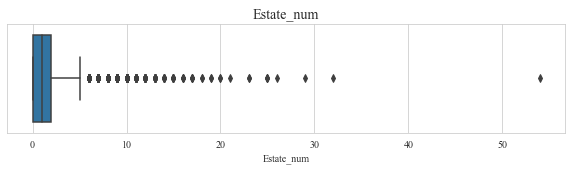

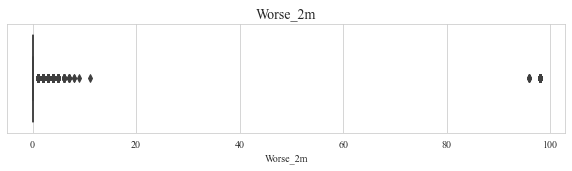

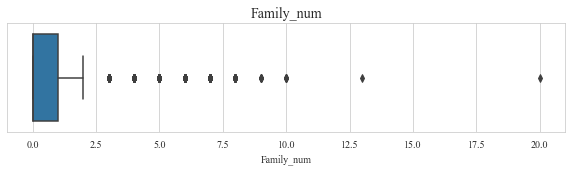

In [93]:
# 箱型图
def box_view(name):
    plt.figure(figsize=(10,2))
    sns.boxplot(data=train_data, x=name)
    plt.title(name, size=14)
    plt.show()
for name in column_names:
    box_view(name)

从箱型图可以侦测出, 部分数据具有极多的outlier, 并且有着相当明显的左偏特征. 为此, 首先计算每个数据的偏度, 对偏度较高的数据做log变换

In [94]:
# 计算偏度
skew =train_data.skew().sort_values(ascending =False )
skew_df= pd.DataFrame({'skew':skew})
skew_df

,skew
Income,113.237098
Debt_r,94.754864
Worse_2m,23.108356
Worse_3m,22.916183
Worse_1m,22.445833
Default,3.708482
Estate_num,3.503003
Family_num,1.595967
Credit_num,1.209343
Balance_r,0.957644


,skew
Worse_2m,11.445603
Worse_3m,9.624215
Worse_1m,4.542786
Debt_r,1.745026
Income,-4.364539


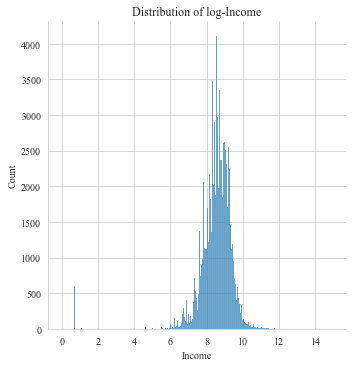

In [95]:
# 将偏度大于10的进行对数变换
skew_index=skew_df[skew_df>10].dropna().index
log_data=np.log(train_data[skew_index]+1)
skew_log =log_data.skew().sort_values(ascending =False )
skew_log=pd.DataFrame({'skew':skew_log})
sns.displot(log_data.Income)
plt.title("Distribution of log-Income", size=12)
skew_log

第一张表格给出了各个数据的偏度, 我们对所有偏度大于10的数据进行对数变换, 并计算对数变换后的偏度. 偏度的数据表明, 对数变换后的分布更加对称(log-Income的图像也验证了这一点). 我们因此, 我们采用对数变换后的数据进行分析

In [101]:
# 得到对数变换后的data, 再次summary并画出箱型图
train_data1=train_data.copy()
train_data1[skew_index]=log_data
train_data1.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
Default,146678.0,0.060,0.237,0.0,0.000,0.000,0.000,1.000
Balance_r,146678.0,0.304,0.338,0.0,0.029,0.144,0.520,1.000
Age,146678.0,52.482,14.763,21.0,41.000,52.000,63.000,109.000
Worse_1m,146678.0,0.139,0.383,0.0,0.000,0.000,0.000,4.595
Debt_r,146678.0,1.529,2.632,0.0,0.161,0.312,0.626,12.706
Income,117495.0,8.415,1.338,0.0,8.137,8.597,9.024,14.917
Credit_num,146678.0,8.500,5.159,0.0,5.000,8.000,11.000,58.000
Worse_3m,146678.0,0.051,0.283,0.0,0.000,0.000,0.000,4.595
Estate_num,146678.0,1.026,1.132,0.0,0.000,1.000,2.000,54.000
Worse_2m,146678.0,0.043,0.259,0.0,0.000,0.000,0.000,4.595


如图所示, 经过对数变换后, outlier情况有所好转, 因此我们接受对数变换的结果, 对于由分布右偏以外的其他因素引起的outlier, 我们用99%的缩尾

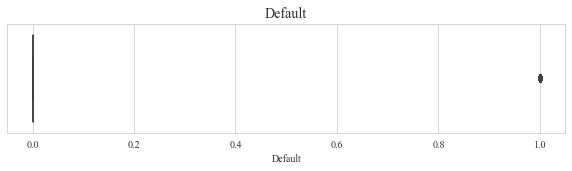

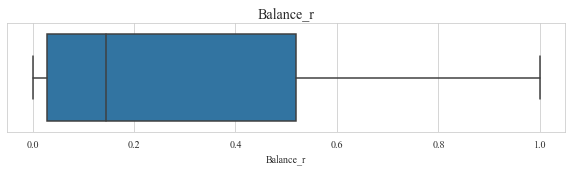

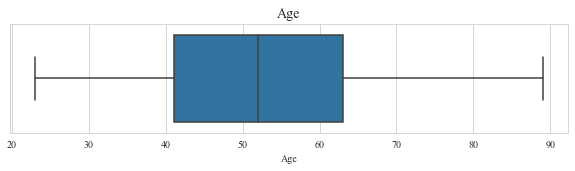

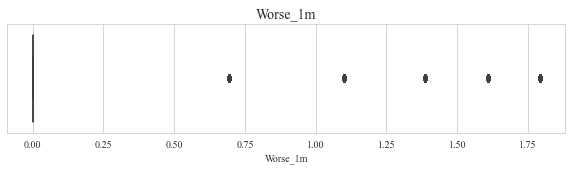

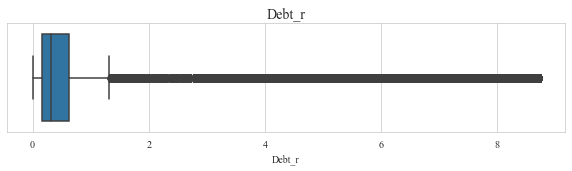

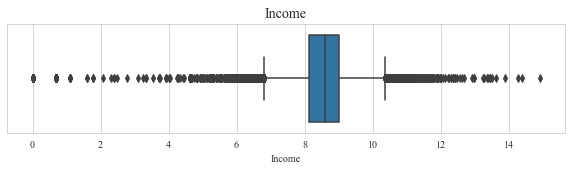

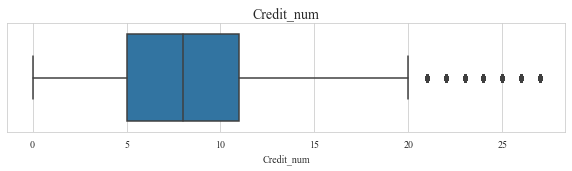

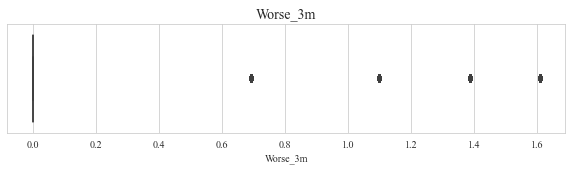

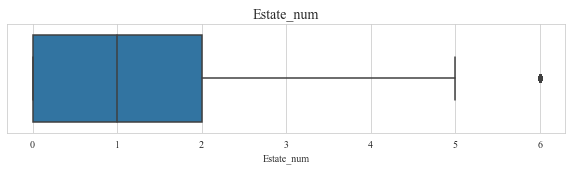

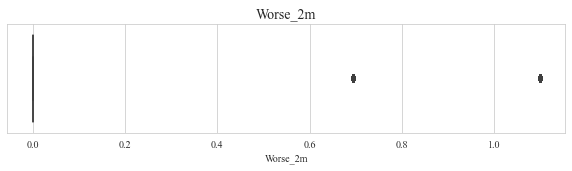

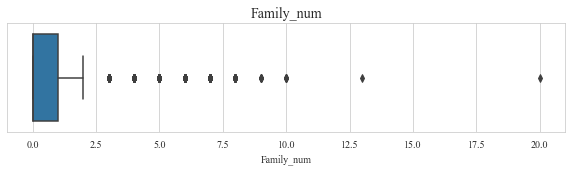

,count,mean,std,min,25%,50%,75%,max
Default,146678.0,0.060,0.237,0.0,0.000,0.000,0.000,1.000
Balance_r,146678.0,0.304,0.338,0.0,0.029,0.144,0.520,1.000
Age,146678.0,52.472,14.711,23.0,41.000,52.000,63.000,89.000
Worse_1m,146678.0,0.134,0.338,0.0,0.000,0.000,0.000,1.792
Debt_r,146678.0,1.527,2.626,0.0,0.161,0.312,0.626,8.731
Income,117495.0,8.415,1.338,0.0,8.137,8.597,9.024,14.917
Credit_num,146678.0,8.474,5.037,0.0,5.000,8.000,11.000,27.000
Worse_3m,146678.0,0.045,0.210,0.0,0.000,0.000,0.000,1.609
Estate_num,146678.0,1.015,1.044,0.0,0.000,1.000,2.000,6.000
Worse_2m,146678.0,0.036,0.168,0.0,0.000,0.000,0.000,1.099


In [97]:
# 进行99%的winsorize缩尾处理
for name in column_names:
    train_data1[name]=winsorize(train_data1[name], limits=[0.005,0.005],nan_policy="omit")
def box_view(name):
    plt.figure(figsize=(10,2))
    sns.boxplot(data=train_data1, x=name)
    plt.title(name, size=14)
    plt.show()
for name in column_names:
    box_view(name)
train_data1.describe().round(3).T

到此为止, 我们给出了整套错误值和离群值的处理办法. 对于处理以后仍然存在的outlier, 我们认为这是正常的现象. 且进一步处理可能会降低后续分析的效度.

# 特征分析

##  分组可视化

In [98]:
#定义按照default分组可视化的函数
def plot_distributions(feature, discrete=True):
    '''

    :param feature: 特征名
    :param discrete: 是否是连续特征
    :return: 按照default与否分组的分布图
    '''
    fig, axes = plt.subplots(1, 2, figsize=(12,3))
    if discrete:
        sns.histplot(train_data1[feature], kde=True, label='Train',stat='density',
                 discrete=True, color='steelblue', alpha=0.6, ax=axes[0])
    else:
        sns.kdeplot(train_data1[feature], label='Train',
                color='steelblue', alpha=0.5, shade=True, edgecolor='k', ax=axes[0])
    axes[0].set_title('Distr of Train set')

    sns.boxplot(x='Default', y=feature, data=train_data1, ax=axes[1], palette=['gold', 'tan'])

    X = train_data1[[feature]].dropna()
    MI = mutual_info_classif(X, train_data1.loc[X.index, 'Default'], discrete_features=True,
                             random_state=0)
    axes[1].set_title('Distribution depending on the Default\n-> Mutual Information: ' + str(round(MI[0], 7)))
    fig.suptitle('{} distributions'.format(feature), y=1.15, fontsize=16)




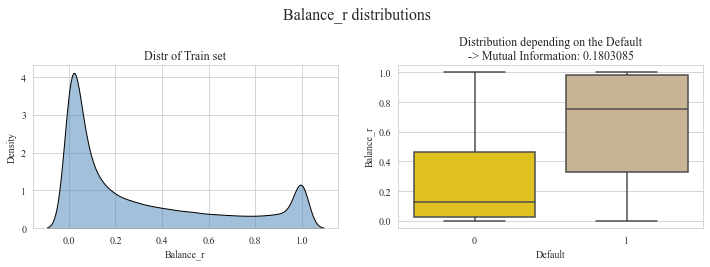

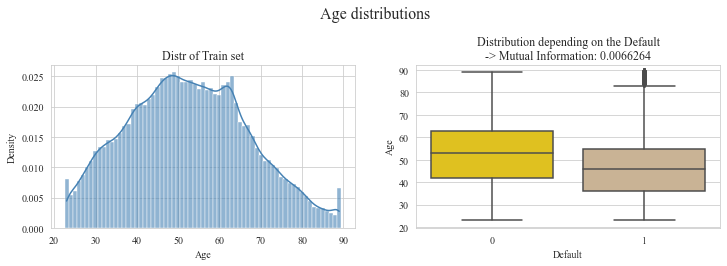

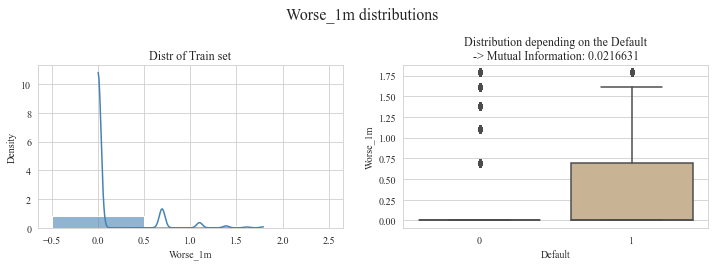

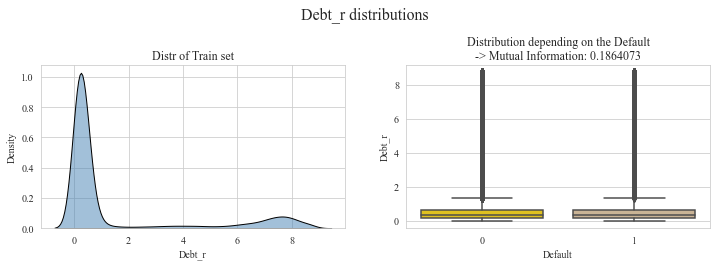

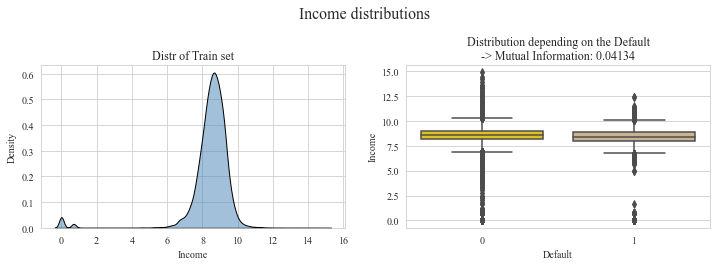

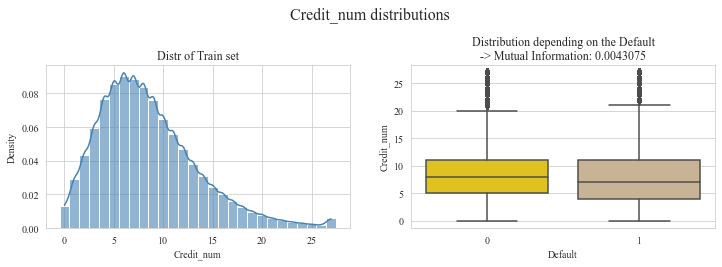

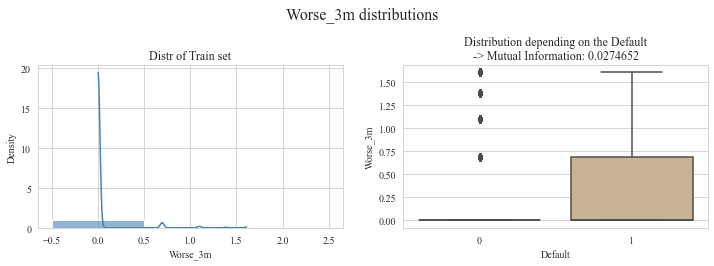

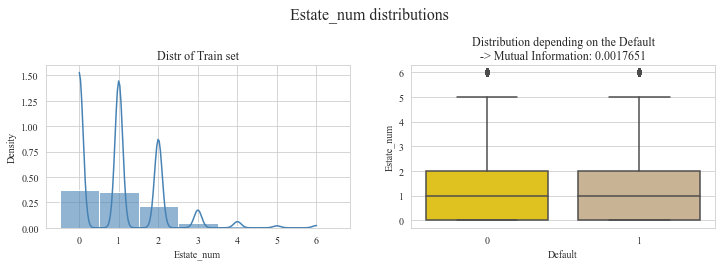

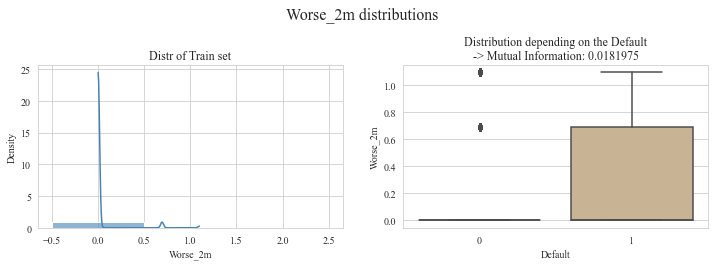

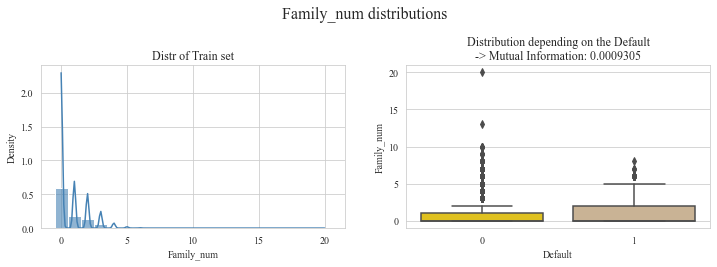

In [99]:
plot_distributions('Balance_r',False)
plot_distributions('Age')
plot_distributions("Worse_1m")
plot_distributions('Debt_r',False)
plot_distributions('Income',False)
plot_distributions("Credit_num")
plot_distributions("Worse_3m")
plot_distributions("Estate_num")
plot_distributions("Worse_2m")
plot_distributions('Family_num')

从上面的图片中可以得到一些基本的结论
1. Balance_r(授信额度/总信用额度)在是否违约的人群中的分布显著不同, 且MI较高, 是比较有效的特征. 从图中可以初步看出, 授信额度占比更高的违约可能性更高
2. Age在是否违约的人群中的分布显著不同, 从图中可以初步看出, 年轻人的违约可能性更高
3. worse_1m, worse_2m, worse_3m 这三个逾期次数是非常有效的特征, 在组间有显著的差异. 从图中可以初步看出, 过去逾期次数多的更容易违约
4. 剩余的几个指标仅从图中来看, 还不能看出存在明显的差异. 需要进一步进行分析


## 相关性分析

### 散点图

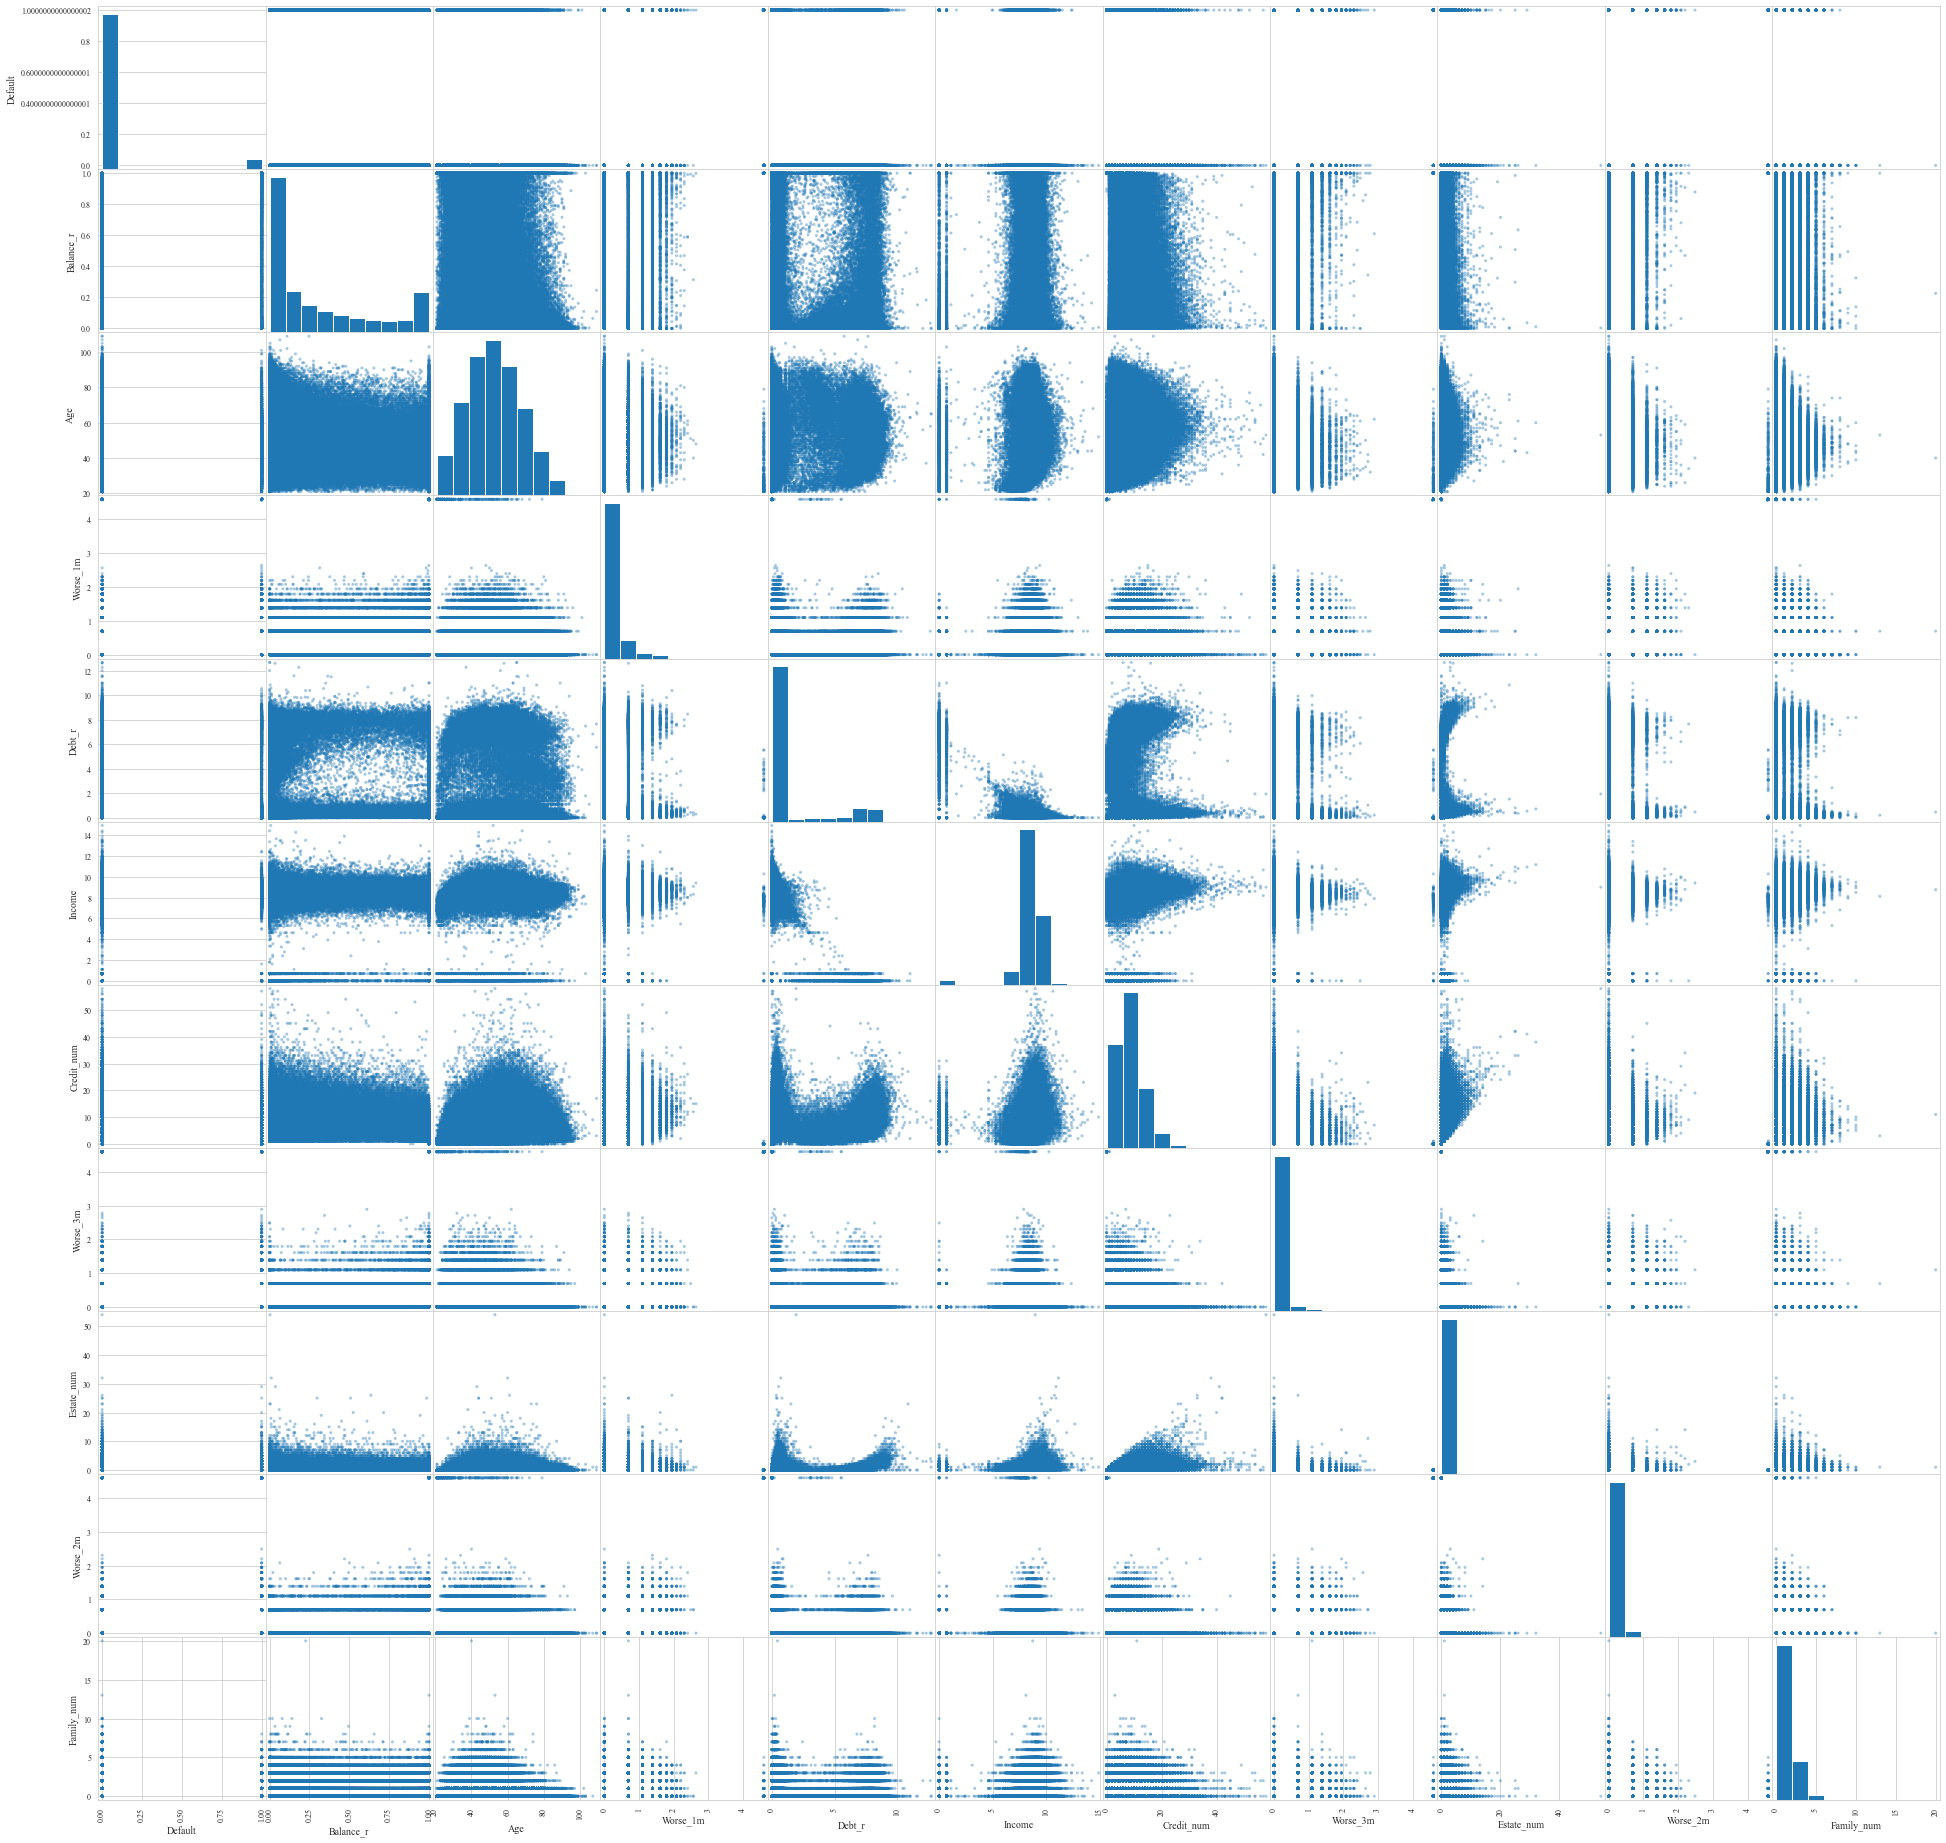

In [111]:
#画出变量两两之间的散点图
with HiddenPrints():
    pd.plotting.scatter_matrix(train_data1[column_names],figsize=(33,33),diagonal='hist',alpha = 0.4,range_padding=0.05)

### Pair plot
其中下半部分包含回归图，以更好的观察相关关系。

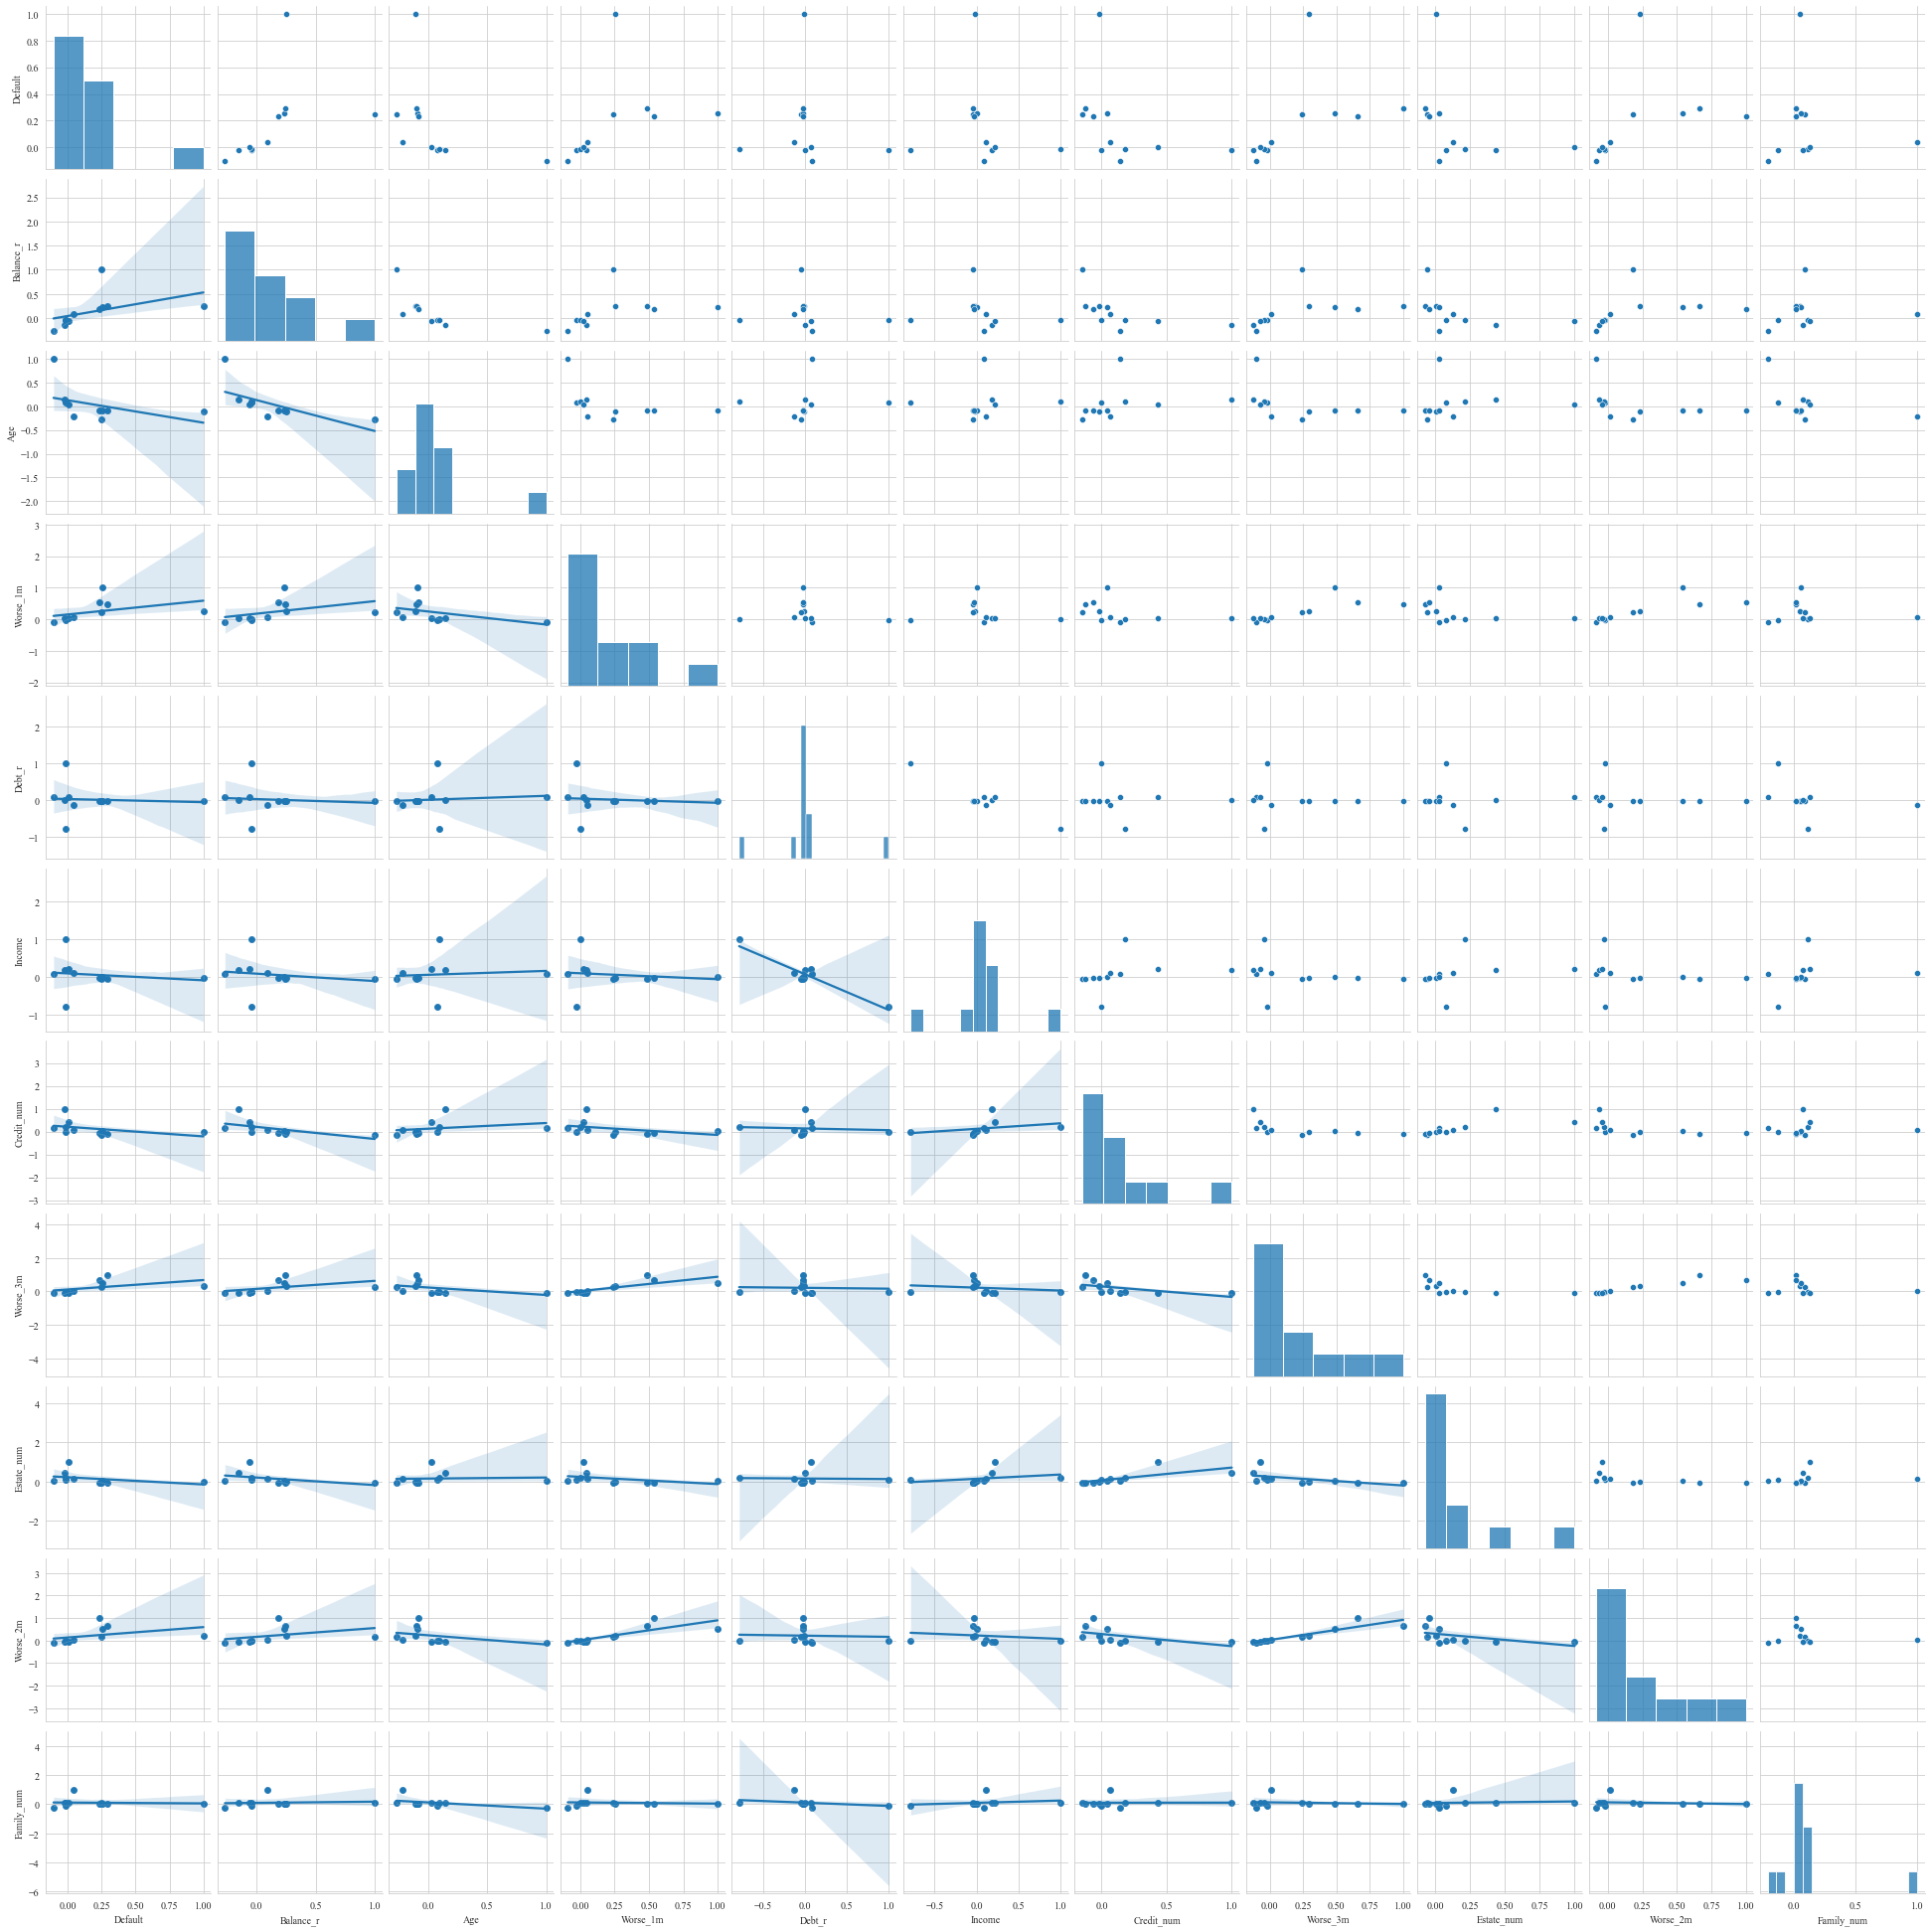

In [118]:
train_data1_corr=train_data1.corr()
g = sns.pairplot(train_data1_corr)
g.map_lower(sns.regplot)

### 相关系数表
散点图并没有那么方便观察, 我们将一幅图用一个量相关系数来描述

In [119]:
#列出两两之间相关系数
train_data1_corr

,Default,Balance_r,Age,Worse_1m,Debt_r,Income,Credit_num,Worse_3m,Estate_num,Worse_2m,Family_num
Default,1.000000,0.249453,-0.105725,0.257055,-0.017076,-0.014723,-0.022230,0.294116,0.002077,0.231298,0.042338
Balance_r,0.249453,1.000000,-0.269399,0.237061,-0.043369,-0.047508,-0.150571,0.242313,-0.058914,0.183892,0.086411
Age,-0.105725,-0.269399,1.000000,-0.091792,0.076185,0.090796,0.142672,-0.099451,0.026479,-0.084269,-0.215212
Worse_1m,0.257055,0.237061,-0.091792,1.000000,-0.025519,0.002485,0.040374,0.488411,0.023498,0.538756,0.052407
Debt_r,-0.017076,-0.043369,0.076185,-0.025519,1.000000,-0.785829,-0.005117,-0.019362,0.075621,-0.019041,-0.133125
Income,-0.014723,-0.047508,0.090796,0.002485,-0.785829,1.000000,0.183308,-0.039787,0.214108,-0.028217,0.107689
Credit_num,-0.022230,-0.150571,0.142672,0.040374,-0.005117,0.183308,1.000000,-0.122689,0.431887,-0.066989,0.067164
Worse_3m,0.294116,0.242313,-0.099451,0.488411,-0.019362,-0.039787,-0.122689,1.000000,-0.075340,0.660746,0.012466
Estate_num,0.002077,-0.058914,0.026479,0.023498,0.075621,0.214108,0.431887,-0.075340,1.000000,-0.041110,0.126911
Worse_2m,0.231298,0.183892,-0.084269,0.538756,-0.019041,-0.028217,-0.066989,0.660746,-0.041110,1.000000,0.013525


### 热量图
将相关系数可视化, 画出热量图便于观察变量间的相关关系

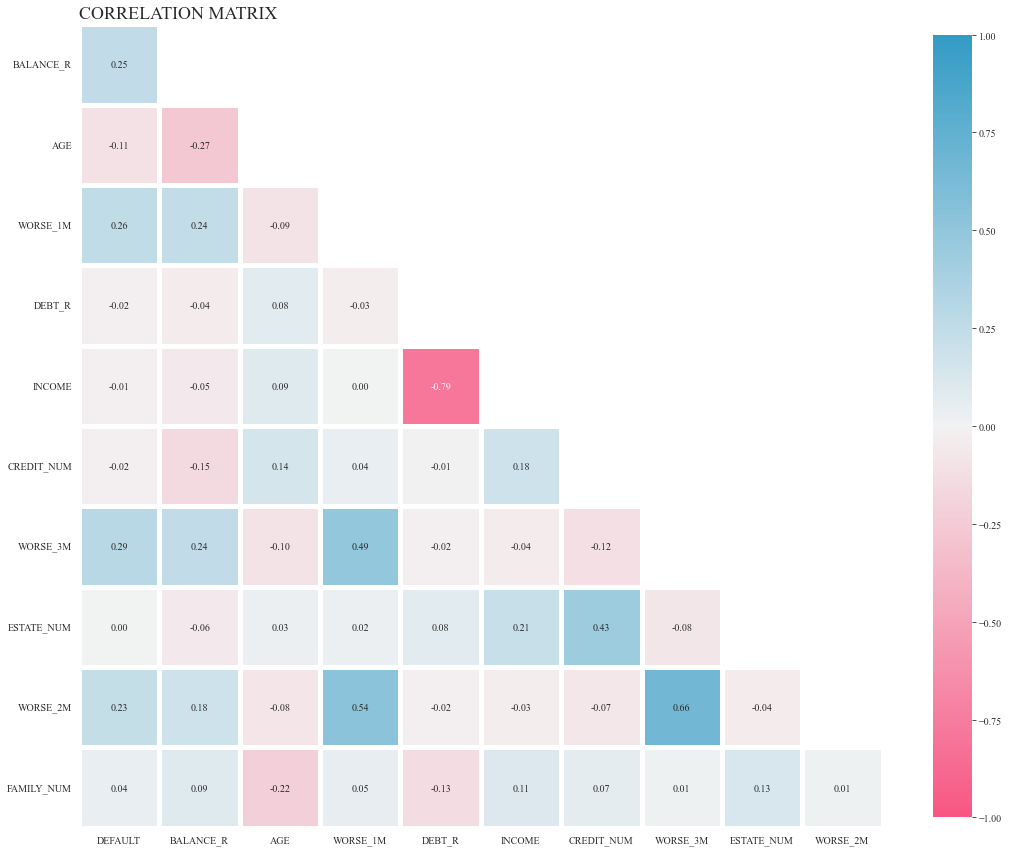

In [120]:
mask=np.triu(np.ones_like(train_data1_corr,dtype=np.bool_))
mask=mask[1:,:-1]
corr=train_data1_corr.iloc[1:,:-1].copy()
plt.figure(figsize=(18,18))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
               linewidths=5, cmap=cmap, vmin=-1, vmax=1,
               cbar_kws={"shrink": .8}, square=True)
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
plt.title('CORRELATION MATRIX', loc='left', fontsize=18)
plt.show()

### 只保留target变量
最后, 我们只看每个变量和target的相关系数

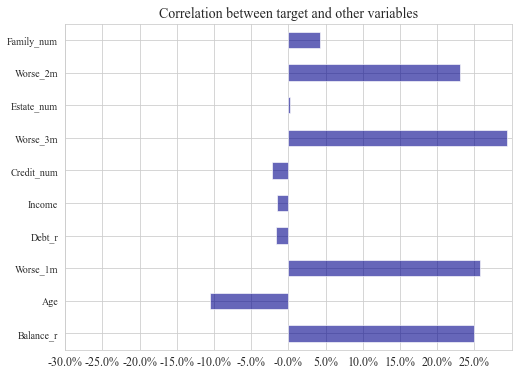

In [140]:
### default和其他变量的相关系数
train_data1.corr()['Default'][1:].plot.barh(figsize=(8,6),alpha=.6,color='darkblue')
plt.xlim(-.3,.3)
x_range=np.arange(-0.3,0.3,0.05)
plt.xticks(x_range, [str((100*i).round(3))+'%' for i in x_range],fontsize=12)
_=plt.title('Correlation between target and other variables',fontsize=14)